Source: https://arxiv.org/abs/1406.5298

In [1]:
from tqdm import tqdm, tqdm_notebook
from mxnet import np, npx
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
from mxnet.gluon.probability import StochasticBlock, StochasticSequential
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage, misc

npx.set_np()
data_ctx = mx.cpu()
model_ctx = mx.gpu(0)

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bz}{\mathbf{z}}$

Our model is defined as follow

$$
p(\bx, y, \bz) = p(\bx \mid y, \bz) p(y) p(\bz)
$$

$$
q(\bz, y \mid \bx) = q(\bz \mid \bx, y) q(y \mid \bx)
$$

In [2]:
class SS_VAE(gluon.HybridBlock):
    def __init__(self, num_classes=10, n_hidden=256, n_latent=2, n_layers=1, n_output=784, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.num_classes = num_classes
        self.output = None
        self.mu = None
        super(SS_VAE, self).__init__(**kwargs)
        self.encoder_z = nn.HybridSequential()
        self.encoder_y = nn.HybridSequential()
        for _ in range(n_layers):
            self.encoder_z.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder_y.add(nn.Dense(n_hidden, activation=act_type))
        self.encoder_z.add(nn.Dense(n_latent*2, activation=None))
        self.encoder_y.add(nn.Dense(num_classes, activation=None))

        self.decoder = nn.HybridSequential()
        for _ in range(n_layers):
            self.decoder.add(nn.Dense(n_hidden, activation=act_type))
        self.decoder.add(nn.Dense(n_output))

    def hybrid_forward(self, F, x, y, observed_mask):
        logit_y = self.encoder_y(x)
        qy_x = mgp.RelaxedOneHotCategorical(T=0.6,
                                            num_events=self.num_classes,
                                            logit=logit_y, F=F)
        py = mgp.RelaxedOneHotCategorical(T=0.6,
                                          num_events=self.num_classes,
                                          logit=F.np.zeros_like(logit_y), F=F)
        y_inferred = qy_x.sample()
        y_mixed = observed_mask * y + (1 - observed_mask) * y_inferred
        loc_scale = F.np.split(
                    self.encoder_z(
                        F.np.concatenate((x, y_mixed), -1)), 2, 1)
        loc = loc_scale[0]
        scale = F.npx.activation(loc_scale[1], 'softrelu')
        qz_xy = mgp.Independent(mgp.Normal(loc, scale, F), 1) # Multivaraite Normal with diagonal covariance
        pz = mgp.Independent(mgp.Normal(F.np.zeros_like(loc), F.np.ones_like(scale), F), 1)
        z = qz_xy.sample()
        recon_logit = self.decoder(F.np.concatenate((qz_xy.sample(), y_mixed), -1))
        # Binary cross entropy for evaluating p(x|y,z)
        px_yz = mgp.Bernoulli(logit=recon_logit)
        recon_loss = px_yz.log_prob(x).sum(-1)
        # Empirical KL divergence
        kl_z = pz.log_prob(z) - qz_xy.log_prob(z)
        kl_y = (py.log_prob(y_inferred) - qy_x.log_prob(y_inferred)) * (1 - observed_mask)
        kl_loss = kl_z + kl_y * 0.0  # remove kl(q(y)||p(y)) to avoid nan            
        # Discriminative objective: q(y|x) on observed y
        supervised_loss = ((F.npx.log_softmax(logit_y, -1) * y) * observed_mask).sum()
        return ((recon_loss + kl_loss).mean(), supervised_loss)

In [60]:
def load_data(batch_size, supervised_rate=0.1):
    # Train set
    mnist_raw = gluon.data.vision.MNIST(train=True)
    train_data = mnist_raw._data
    train_label = npx.one_hot(mnist_raw._label, 10)
    len_train = train_label.shape[0]
    # Whether to corrupt labels
#     np.random.shuffle(train_label)
    idx = np.random.choice(np.arange(train_label.shape[0]), size=int(len_train * (1 - supervised_rate)), replace=False)
    train_label[idx] = -np.ones_like(train_label[0]) # Set unobserved labels to be -1
    
    mnist_train = gluon.data.ArrayDataset(train_data, train_label)
    
    # Test set
    mnist_test = gluon.data.vision.MNIST(train=False)
    num_worker = 8
    transformer = gluon.data.vision.transforms.ToTensor()
    return (gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                batch_size, shuffle=True,
                                num_workers=num_worker, thread_pool=True, pin_memory=True),
          gluon.data.DataLoader(mnist_test.transform_first(transformer),
                                batch_size, shuffle=False,
                                num_workers=num_worker, thread_pool=True))
                                 

In [61]:
def train(net, n_epoch, print_period, train_iter, test_iter):
    net.initialize(mx.init.Xavier(), ctx=model_ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                          {'learning_rate': .001})
    training_loss = []
    validation_loss = []
    loss_func = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=True)
    metric = mx.gluon.metric.Accuracy()
    alpha = 32.
    for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
        metric.reset()
        epoch_loss = 0
        epoch_val_loss = 0
        n_batch_train = 0
        for (img, label) in train_iter:
            n_batch_train += 1
            x = img.copyto(model_ctx).reshape(-1, 28 * 28)
            y = label.copyto(model_ctx)
            mask = np.expand_dims(np.all(y >= 0, -1), -1).astype('float32')
            with autograd.record():
                g_loss, d_loss = net(x, y, mask)
                loss = -(g_loss + alpha * d_loss)
            loss.backward()
            trainer.step(x.shape[0])
            epoch_loss += np.mean(loss).detach().copy()
        
        n_batch_val = 0
        for (img, label) in test_iter:
            n_batch_val += 1
            x = img.copyto(model_ctx).reshape(-1, 28 * 28)
            y = npx.one_hot(label.copyto(model_ctx), 10)
            logit = net.encoder_y(x)
            metric.update([label], [logit.as_nd_ndarray()])

        epoch_loss /= n_batch_train
        name, acc = metric.get()
        print('[Epoch %d] Training: %s=%f'%(epoch, name, acc))
        print('Epoch{}, Training loss {:.2f}'.format(
              epoch, float(epoch_loss)))
#         training_loss.append(epoch_loss)
#         validation_loss.append(epoch_val_loss)

#         if epoch % max(print_period, 1) == 0:
#             print('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(
#               epoch, float(epoch_loss), float(epoch_val_loss)))

In [64]:
# net2 = net

In [65]:
n_hidden = 400
n_latent = 32
n_layers = 2  # num of dense layers in encoder and decoder respectively
n_output = 784
batch_size = 128
model_prefix = 'vae_gluon_{}d{}l{}h.params'.format(
  n_latent, n_layers, n_hidden)
net = SS_VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers,
        n_output=n_output)
n_epoch = 5
print_period = 1
train_set, test_set = load_data(batch_size)
#     start = time.time()
train(net, n_epoch, print_period, train_set, test_set)
#     end = time.time()
#     print('Time elapsed: {:.2f}s'.format(end - start))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


[Epoch 0] Training: accuracy=0.913000
Epoch0, Training loss 341.95
[Epoch 1] Training: accuracy=0.935400
Epoch1, Training loss 190.01
[Epoch 2] Training: accuracy=0.942400
Epoch2, Training loss 152.33
[Epoch 3] Training: accuracy=0.931400
Epoch3, Training loss 137.71
[Epoch 4] Training: accuracy=0.941400
Epoch4, Training loss 123.74



In [11]:
test_img = None
test_label = None
for (img, label) in test_set:
    x = img.copyto(model_ctx).reshape(-1, 28 * 28)
    y = npx.one_hot(label.copyto(model_ctx), 10)
    test_img = x
    test_label = y
    break

## Reconstruction

In [12]:
z_xy = net.encoder_z(np.concatenate((test_img, test_label), -1))[:,:n_latent]
origin_img = test_img.asnumpy().reshape(-1, 28, 28)
recon = npx.sigmoid(net.decoder(np.concatenate((z_xy, test_label), -1))).asnumpy().reshape(-1, 28, 28)

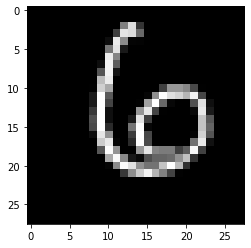

In [13]:
plt.imshow(origin_img[100], cmap='gray')

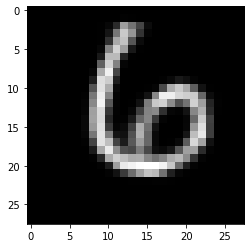

In [14]:
# Reconstruction
plt.imshow(recon[100], cmap='gray')

## Conditional Generation with corrupted label

Changing $y$ has no effect on the final output.

In [16]:
num_samples = 16
label_6 = npx.one_hot(np.array([[6],]), 10).copyto(model_ctx).repeat(num_samples, axis=1).squeeze()
# samples from prior
noise = np.random.normal(size=(num_samples, n_latent), ctx=model_ctx)
samples = npx.sigmoid(net.decoder(np.concatenate((noise, label_6), -1))).asnumpy().reshape(-1, 28, 28)

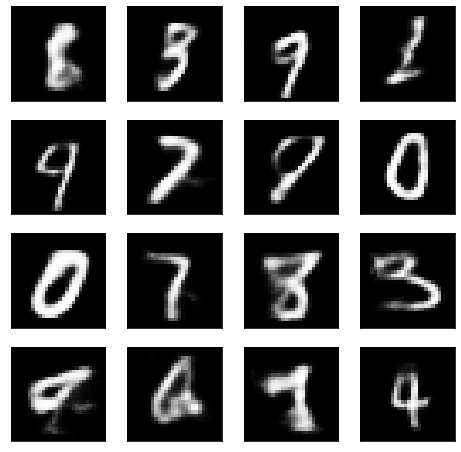

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8),
                             subplot_kw={'xticks': [], 'yticks': []})

for i in range(16):
    axes[int(i / 4), i % 4].imshow(samples[i], cmap='gray')

## Decoder weights with corrputed labels

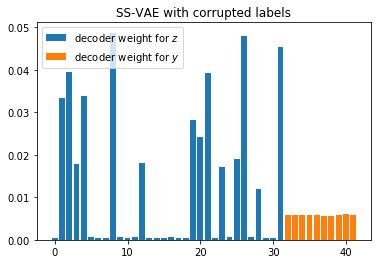

In [59]:
x = np.arange(32).asnumpy()
barlist = plt.bar(x, (net.decoder[0].weight.data() ** 2).mean(0).asnumpy()[:32], alpha=1.0, label='decoder weight for $z$')
# for i in range(32):
#     barlist[i].set_color('r')
x = (np.arange(10)).asnumpy() + 32
barlist = plt.bar(x, (net.decoder[0].weight.data() ** 2).mean(0).asnumpy()[32:], alpha=1.0, label='decoder weight for $y$')
plt.legend()
plt.title("SS-VAE with corrupted labels")
plt.savefig("ssvae_cl.pdf")

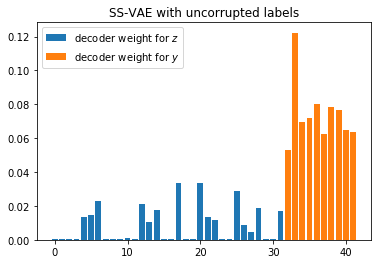

In [66]:
x = np.arange(32).asnumpy()
barlist = plt.bar(x, (net.decoder[0].weight.data() ** 2).mean(0).asnumpy()[:32], alpha=1.0, label='decoder weight for $z$')
# for i in range(32):
#     barlist[i].set_color('r')
x = (np.arange(10)).asnumpy() + 32
barlist = plt.bar(x, (net.decoder[0].weight.data() ** 2).mean(0).asnumpy()[32:], alpha=1.0, label='decoder weight for $y$')
plt.legend()
plt.title("SS-VAE with uncorrupted labels")
plt.savefig("ssvae_ucl.pdf")